# Fundamental Frequency Estimation

Additional Resources

[[1] Gerhard survey](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.834&rep=rep1&type=pdf)

[[2]Illinois ECE420 notes](https://courses.engr.illinois.edu/ece420/sp2019/4_PitchDetermination.pdf)

[[3] Wikipedia](https://en.wikipedia.org/wiki/Pitch_detection_algorithm)

In [107]:
import librosa
import os
from os import path
import scipy as sp
import numpy as np
import IPython.display as ipd
from librosa import load
from librosa.display import waveplot, specshow
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
data_dir = "data"

In [3]:
def plot_spec(signal, sr=16000, win_length=None, hop_length=None, return_spec=False):
    if win_length is None:
        win_length = int(sr * 0.030)
        
    if hop_length is None:
        hop_length = int(sr * 0.010)
        
    Sxx = librosa.core.stft(
        signal,
        win_length=win_length,
        hop_length=hop_length,
        n_fft=4096
    )
    spec = librosa.amplitude_to_db(np.abs(Sxx), ref=np.max)
    
    specshow(
        spec,
        sr=sr,
        x_axis='time',
        y_axis='hz',
        cmap='gray_r'
    )
    plt.colorbar(format='%+2.0f dB')
    
    if return_spec:
        return spec

In [119]:
def pure_tone(f, t):
    return np.sin(2 * np.pi * f * t)


def harmonized_tone(f, t):
    signal = pure_tone(f, t)
    for multiple in np.arange(2, 10):
        signal += np.exp(-multiple) * pure_tone(f * multiple, t)
    return signal


def harmonized_tone_no_f0(f, t):
    signal = np.zeros((len(t),))
    for multiple in np.arange(2, 10):
        signal += np.exp(-multiple) * pure_tone(f * multiple, t)
    return signal


def overlapping_harmonized_tones(f, t):
    # start with a first tone, and add in a tone (same harmonic structure) with an f0 that is half that of the first signal
    return harmonized_tone(f, t) + harmonized_tone(int(f/2.), t)

f = 1000
sr = 16000
fs = sr
n_seconds = 1
t = np.linspace(0, n_seconds, sr * n_seconds)

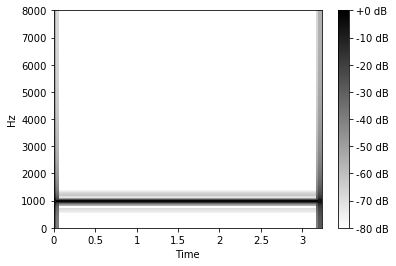

In [13]:
x = pure_tone(f, t)

plot_spec(x, sr=sr)
ipd.Audio(x, rate=sr)

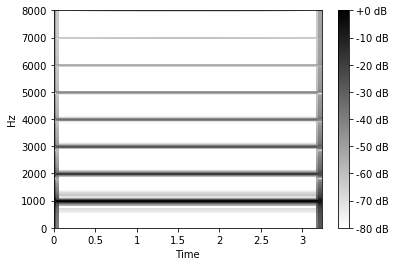

In [14]:
x = harmonized_tone(f, t)

plot_spec(x, sr=sr)
ipd.Audio(x, rate=sr)

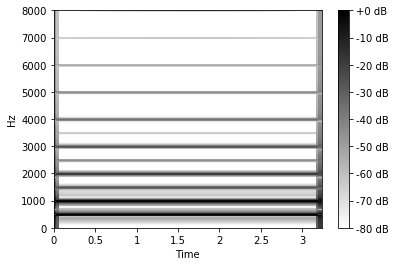

In [15]:
x = overlapping_harmonized_tones(f, t)

plot_spec(x, sr=sr)
ipd.Audio(x, rate=sr)

# Tones without their fundamental frequency
What about if we remove the fundamental frequency of a tone, leaving its harmonic structure in place? Would it sound just as pleasing, or would something sound off?

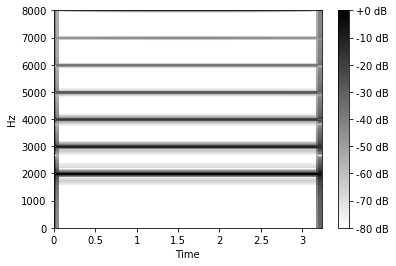

In [8]:
x = harmonized_tone_no_f0(f, t)

plot_spec(x, sr=sr)
ipd.Audio(x, rate=sr)

I claim this sounds harsher than the previous tone. You might think that, since the harmonic structure is still in place, that it might sound similar to a 2 kHz tone. However, this is not the case; the augmented tone still has harmonics at odd multiples of 1000, w

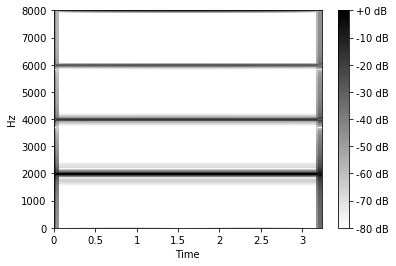

In [9]:
x = harmonized_tone(2000, t)

plot_spec(x, sr=sr)
ipd.Audio(x, rate=sr)

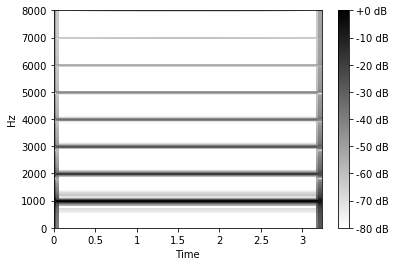

In [44]:
x = harmonized_tone(f, t)

plot_spec(x, sr=sr)
ipd.Audio(x, rate=sr)

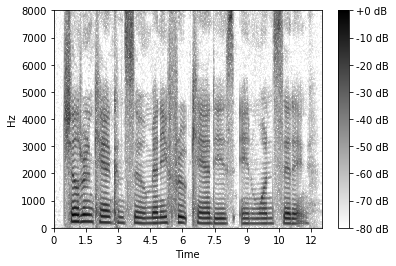

In [130]:
import essentia
from essentia.standard import PitchYin, PitchYinFFT
from librosa.util import frame, normalize
from librosa.core import stft

sr = 16000
x, _ = load('data/wave/1.wav', sr=sr)
x = normalize(x)

win_length = int(sr*0.020)
hop_length = int(sr*0.010)

plot_spec(x, sr=sr)
ipd.Audio(x, rate=sr)


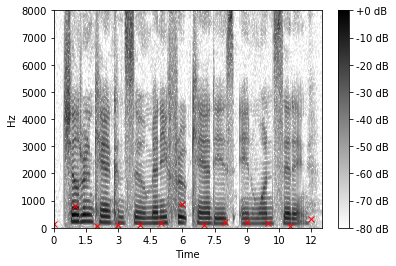

In [132]:
frames = frame(
    x,
    frame_length=win_length,
    hop_length=hop_length
)

'''
http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf
https://essentia.upf.edu/documentation/reference/std_PitchYin.html
'''

stft_frames = np.abs(stft(
    x,
    win_length=win_length,
    hop_length=hop_length,
    window='hanning',
    n_fft=1024
))

f0_est = PitchYin(
    interpolate=True,
    sampleRate=sr,
    minFrequency=20,
    maxFrequency=int(fs/2.)
)

for i in range(stft_frames.shape[1]):
    f0, confidence = f0_est(stft_frames[:, i])
    if confidence > 0:
        plt.plot(i, f0, color='r', marker='x')

plot_spec(x, sr=sr, win_length=win_length, hop_length=hop_length)